In [501]:
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from multiprocessing import Pool

import torchvision
from torchvision import models as tvmodels
from torchsummary import summary

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchvision.models as torchvisionmodels

import os
import numpy as np
import cv2
import argparse
import sys

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import itertools
import more_itertools

import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from captum.attr import LayerGradCam
from captum.attr import visualization
from PIL import Image
import shutil

import numpy as np
from dask_image.imread import imread
from dask_image import ndfilters, ndmorph, ndmeasure
import matplotlib.pyplot as plt
from dask_image import ndmeasure

from operator import itemgetter
from time import perf_counter

In [502]:
import torch
from trainer import *

allowed_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
labels_map = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}

batch_size = 1

# model = MNIST_model(len(allowed_classes))
# checkpoint = torch.load('resnet_models/resnet18.pt')
# model.load_state_dict(checkpoint)

model_dict = torch.load('resnet_models/grad_cam_model.pt')
model = gradcam_model()
model.load_state_dict(model_dict)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data, valid_data, test_data = create_dataloaders_MNIST(batch_size)

model.to(device)
model.eval()
print("Model and data loaded")

Model and data loaded


In [503]:
good_img_transform = transforms.Normalize((0.1307,), (0.3081,))
# This is to reverse the normalization done to the images that centered them around imagenet mean and std
# The invTrans should be used on images before saving them.
invTrans = transforms.Normalize((1/0.1307,), (1/0.3081,))


tensor([7])
tensor([7], device='cuda:0')


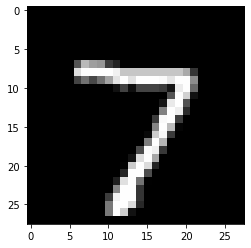

In [504]:
torch.manual_seed(0)
#images, labels = next(itertools.islice(testloader, 48, None))
images, labels = next(itertools.islice(test_data, 0, None))

print(labels)
outputs = model(images.to(device))
_, predicted = outputs.max(1)
print(predicted)
pred_val = predicted.item()
plt.imshow( images.detach().cpu().squeeze(), cmap='gray' )

# Good sevens: 5, 8, 9, 13, 16, 17, 18

In [505]:
from skimage import segmentation
from pytorch_grad_cam import XGradCAM, GradCAM, FullGrad, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from skimage.segmentation import slic, felzenszwalb, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import sobel

In [506]:
def get_grayscale_grad_cam(image, SMU_class_index):
    input_tensor = image.to(device)
    targets = [ClassifierOutputTarget(SMU_class_index)]
    #target_layers = [model.layer4[-1]]
    target_layers = [model.layer2]
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return(grayscale_cam)

def segmentation_info(image, num_segments, compactness):
    img_np = image.detach().cpu().squeeze().numpy()
    segments_slic = slic(img_np, n_segments = num_segments, compactness=compactness,
                     start_label=1)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)


# I want to get the average attribution score for each segment
def cam_processor_for_segments(grayscale_cam_output, segments_slic):
    list_unique_regions = np.unique(segments_slic)
    region_attr_score = []
    final_region_attr_score = []
    num_pixels_in_region_list = []
    
    for i in (list_unique_regions):
        row_counter = 0
        column_counter = 0
        region_attr_score = []
        num_pixels_in_region = 0
        for row in grayscale_cam_output:
            for cell in row:
                current_score = grayscale_cam_output[row_counter, column_counter]
                current_region = segments_slic[row_counter, column_counter]
                if current_region == i:
                    region_attr_score.append(current_score)
                    num_pixels_in_region += 1
                column_counter +=1
            row_counter += 1
            column_counter = 0
        avg_score = np.mean(region_attr_score)
        final_region_attr_score.append(avg_score)
        num_pixels_in_region_list.append(num_pixels_in_region)
    
    unique_region_info = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(final_region_attr_score[i-1])
        image_list.append(num_pixels_in_region_list[i-1])
        image_list.append(np.sum(num_pixels_in_region_list))
        unique_region_info.append(image_list)
    
    return(unique_region_info)


def get_feature_masks(image, attributions, segments_slic):
    segments_slic_1 = segments_slic
    features = []
    for i in attributions:
        feature = np.where(i==segments_slic_1, 1, 0)
        features.append(feature)
        
    return(features)


def attribution_ranker(cam_processor_for_segments_output, num_top_attr):
    ranked_images = sorted(cam_processor_for_segments_output, key=itemgetter(1), reverse=True)
    top_ranked_features = []
    for i in range(num_top_attr):
        top_ranked_features.append(ranked_images[i][0])
        
    return top_ranked_features



def image_rankings(get_image_versions):
    #for idx in iterative_Grad_CAM_counterfactual_masking_output
    ranked_images = sorted(get_image_versions, key=itemgetter(3))
    
    return ranked_images

def blur_image_from_attribution(image, attribution_map):
    # attribution map is the attributions after being passed through the attribution processor
    # image is a tensor
    # will output the blurred image based on the attribution map
    
    
    #average_img = image.squeeze().cpu().permute(1, 2, 0).numpy()
    #avg = np.average(average_img)
    #blurred_img = cv2.GaussianBlur(image.squeeze().cpu().permute(1, 2, 0).numpy(), (181, 181), 0)
    avg = np.float32(-0.4242)
    #avg_img = np.where(average_img > 9999, average_img, avg)
    
    #attribution_map = attribution_map.detach().squeeze().cpu().numpy()
    
    mask = [attribution_map]
    mask = np.array(mask).squeeze()

    out = np.where(mask==np.array([0]), image.squeeze().cpu().numpy(), avg)

    return torch.tensor(out).unsqueeze(0).unsqueeze(0)


In [507]:
def segmentation_info_slic(image, num_segments, compactness):
    img_np = image.detach().cpu().squeeze().numpy()
    segments_slic = slic(img_np, n_segments = num_segments, compactness=compactness,
                     start_label=1)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)


def segmentation_info_felzenszwalb(image, scale, sigma, min_size):
    img_np = image.detach().cpu().squeeze().numpy()
    segments_felz = felzenszwalb(img_np, scale=scale, sigma=sigma, min_size=min_size)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)


def softmax_score(num_total_pixels, num_obf_pixels, model, image, SMU_class_index):
    #image = good_img_transform(image)
    image = image
    logits = model(image).cpu()
    #print(logits)
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    probs = probs[SMU_class_index]

    return probs


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def region_explainability(image, top_n_start: int, model: torch.nn.Module, 
                          SMU_class_index, threshold: float, 
                          top_n_stop: int, MAX_BATCH_SZ: int = 16,
                          PRUNE_HEURISTIC: int = 3):
    if not(next(model.parameters()).is_cuda):
        print('Model is not on GPU')
        return -1
    # Get attribution map
    explainability_mask = get_grayscale_grad_cam(image,SMU_class_index)
    # Get segment mask
    seg = segmentation_info_slic(image = image, num_segments = 25, compactness = 1)
    # Calculate average attribution in each superpixel
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = explainability_mask, 
                                                 segments_slic = seg[1])
    # Sort the regions by average attribution, make num_top_attr = the number of segments in the image
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, 
                                   num_top_attr = seg[2])
    features_1 = get_feature_masks(image = image, attributions = top_attrs, 
                                   segments_slic = seg[1])
    # features_1 gives us a sorted list of feature masks. 
    # Element at position 0 is the top attribution region mask
    top_n = top_n_start
    score = 1000
    prob = 1
    
    sm1 = softmax(model(image.to(device)).cpu().detach().numpy()).squeeze()
    sm_idx1 = np.unravel_index(np.argmax(sm1), sm1.shape)[0]
    prediction = sm_idx1 
    confidence = sm1[sm_idx1]

    powerset_list = [0] 
    total_images_analyzed = 0
    searches_in_current_depth = 0
    best_masked_image = None
    start = perf_counter()
    print('Starting with region search depth:', top_n)
    features_list = features_1[0:top_n]
    features_nums = list(range(len(features_list)))
    powerset_list = list(more_itertools.powerset(features_nums))
    powerset_list = [ele for ele in powerset_list if len(ele) != 0]
    unique_image_info = []
    #num_pixels_changed holds the count of the number of pixels that are obfuscated
    num_pixels_changed = []
    #total_attr_list I think gives us the label of the regions that are being obfuscated
    total_attr_list = []
    #scores holds the score given to the image with regions obfuscated
    scores = []
    while True:
        
        # getting all combinations of features as a list, based on their index
        if searches_in_current_depth == len(powerset_list):
            top_n += 1
            # PRUNE_HEURISTIC += 1
            searches_in_current_depth = 0
            features_list = features_1[0:top_n]
            features_nums = list(range(len(features_list)))
            powerset_list = list(more_itertools.powerset(features_nums))
            powerset_list = [ele for ele in powerset_list if features_nums[-1] in ele]
            # powerset_list = [ele for ele in powerset_list if len(ele) > PRUNE_HEURISTIC]
            print('Number of images analyzed so far:', total_images_analyzed)
            print('Increasing search depth to', top_n, 'regions\n')        
        
        should_use_max_batch_size = MAX_BATCH_SZ <= len(powerset_list) - searches_in_current_depth
        if should_use_max_batch_size:
            batch_size = MAX_BATCH_SZ
        else:
            batch_size = len(powerset_list) - searches_in_current_depth
        
        image_tensor_batch = torch.zeros(batch_size, 1, 28, 28).to(device)
        total_attribution = list()
        num_changes = list()
        total_num_pixels = list()
        
        for num in range(batch_size):
            total_attribution.append(np.zeros((28, 28)))
            num_changes.append(np.count_nonzero(total_attribution))
            total_num_pixels.append(total_attribution[-1].size)
            for i in range(len(powerset_list[searches_in_current_depth])):
                total_attribution[num] += features_list[powerset_list[searches_in_current_depth][i]]
            obfuscated_image = blur_image_from_attribution(image = image,
                               attribution_map = total_attribution[num]).to(device)
            image_tensor_batch[num] = obfuscated_image.detach().clone().squeeze(0)
            searches_in_current_depth += 1
            
        np_output = model(image_tensor_batch).cpu().detach().numpy()
        sm2 = np.apply_along_axis(softmax, 1, np_output)
        sm_idx2 = np.unravel_index(np.argmax(sm2), sm2.shape)
        img_index = sm_idx2[0]
        cf_prediction = sm_idx2[1]
        cf_confidence = sm2[sm_idx2]
        total_images_analyzed += batch_size
        if (prediction != cf_prediction) and (cf_confidence > threshold):
            unique_image_info.append(image_tensor_batch[img_index])
            unique_image_info.append(num_changes[img_index])
            unique_image_info.append(total_num_pixels[img_index])
            unique_image_info.append([confidence, cf_confidence])
            unique_image_info.append([prediction, cf_prediction])
            unique_image_info.append(total_attr_list)
            unique_image_info.append(top_n)
            unique_image_info.append(avg_attr_scores)
            unique_image_info.append(total_images_analyzed)
            print('Counterfactual found at depth:', top_n, 'regions')
            print('Total Number of Counterfactuals tested:', total_images_analyzed)
            end = perf_counter() - start
            print(f'Total Search time: {end:.2f}')
            break
            
        if top_n == top_n_stop and searches_in_current_depth == len(powerset_list):
            print('Counterfactual not found up to depth (including):', top_n, 'regions')
            print('Total Number of Counterfactuals tested:', total_images_analyzed)
            end = perf_counter() - start
            print(f'Total Search time: {end:.2f}')
            return -1
        
        
    return unique_image_info

tensor([7])
tensor([7], device='cuda:0')


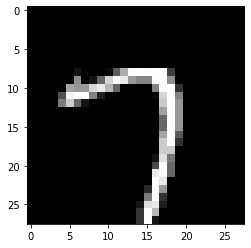

In [508]:
torch.manual_seed(0)
#images, labels = next(itertools.islice(testloader, 48, None))
images, labels = next(itertools.islice(test_data, 26, None))

print(labels)
outputs = model(images.to(device))
_, predicted = outputs.max(1)
print(predicted)
pred_val = predicted.item()
plt.imshow( images.detach().cpu().squeeze(), cmap='gray' )

# Good sevens: 0, 

In [509]:
i = 0
n = 0
while i < 10:
    torch.manual_seed(0)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    #images, labels = next(itertools.islice(testloader, n, None))
    images, labels = next(itertools.islice(test_data, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    
    if just_label == 7 and predicted == 7:
        print('index:', n)
        i += 1
    
    n += 1

index: 0
index: 17
index: 26
index: 34
index: 36
index: 41
index: 60
index: 64
index: 70
index: 75


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


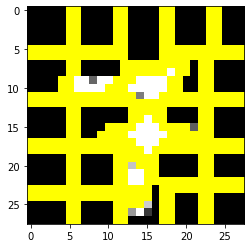

In [510]:
inv_img = images
img_np = inv_img.detach().cpu().squeeze().numpy()
#plt.imshow(img_np)
# compactness=50
segments_slic = slic(img_np, n_segments=25, compactness=1,
                     start_label=1)
plt.imshow(segmentation.mark_boundaries(img_np, segments_slic))

In [511]:
# working_example = region_explainability(image = images, top_n_start = 1, model = model, SMU_class_index = 1)

tensor([7])
tensor([7], device='cuda:0')


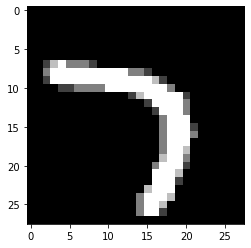

In [512]:
torch.manual_seed(0)
#images, labels = next(itertools.islice(testloader, 48, None))
images, labels = next(itertools.islice(test_data, 60, None))

print(labels)
outputs = model(images.to(device))
_, predicted = outputs.max(1)
print(predicted)
pred_val = predicted.item()
plt.imshow( images.detach().cpu().squeeze(), cmap='gray' )

# Good sevens:index: 0, 17, 26, 34, 36, 41, 60, 64, 70, 75
# Good outputs 17, 48, 

0.0


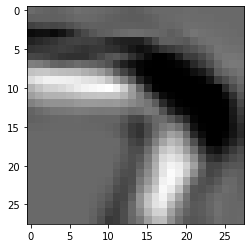

In [513]:
input_tensor = images.to(device)
targets = [ClassifierOutputTarget(7)]
target_layers = [model.layer2]
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.min())
plt.imshow(grayscale_cam, cmap='gray', vmin=0, vmax=1)

torch.Size([1, 1, 28, 28])
Starting with region search depth: 4
Number of images analyzed so far: 15
Increasing search depth to 5 regions

Number of images analyzed so far: 31
Increasing search depth to 6 regions

Number of images analyzed so far: 63
Increasing search depth to 7 regions

Number of images analyzed so far: 127
Increasing search depth to 8 regions

Number of images analyzed so far: 255
Increasing search depth to 9 regions

Number of images analyzed so far: 511
Increasing search depth to 10 regions



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Counterfactual found at depth: 10 regions
Total Number of Counterfactuals tested: 783
Total Search time: 0.14
regions analyzed 10
Original Version Predicted Class: 7      With Confidence: 0.9999999
Modified Version Predicted Class: 1      With Confidence: 0.9956826


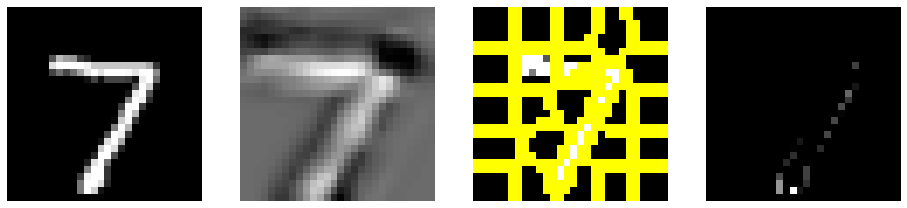

In [514]:
# Just give an images and it will output

index = 0
class_target = 7
top_n_start = 4
top_n_stop = 20
threshold = 0.92
# pruning_heurist is disabled atm, it almost works!
pruning_heuristic = 1
# batch size of 16 appears to be optimal for search speed
# can do 20 regions in ~3 minutes!
batch_sz = 16
images, labels = next(itertools.islice(test_data, index, None))

input_tensor = images.to(device)
targets = [ClassifierOutputTarget(class_target)]
target_layers = [model.layer2]
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

inv_img = images
print(inv_img.shape)
img_np = inv_img.detach().cpu().squeeze().numpy()
#plt.imshow(img_np)
# compactness=50
segments_slic = slic(img_np, n_segments=25, compactness=1,
                     start_label=1)

fast_model = torch.jit.trace(model.to(device), torch.zeros(batch_sz, 1, 28, 28).to(device))

working_example = region_explainability(image = images, top_n_start = top_n_start, 
                                        model = fast_model, SMU_class_index = class_target, 
                                        threshold = threshold, top_n_stop = top_n_stop,
                                        MAX_BATCH_SZ = batch_sz,
                                        PRUNE_HEURISTIC = pruning_heuristic)

ori_prediction = working_example[4][0]
ori_confidence = working_example[3][0]
cf_prediction = working_example[4][1]
cf_confidence = working_example[3][1]

print("regions analyzed", working_example[-3])
print("Original Version Predicted Class:", ori_prediction, 
      "     With Confidence:", ori_confidence)
print("Modified Version Predicted Class:", cf_prediction, 
      "     With Confidence:", cf_confidence)

plot_images = (images.detach().cpu().squeeze(),
              grayscale_cam,
              segmentation.mark_boundaries(img_np, segments_slic),
              working_example[0].detach().cpu().squeeze())

figure_name = plt.figure(figsize=(16, 16))
for i, img in enumerate(plot_images):
        plt.subplot(1, 4,i+1)
        plt.axis('off')
        plt.imshow(img, cmap='gray',interpolation='none')
figure_name.savefig('test.png')

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
# fig.figure(figsize=(12, 12))
# ax1.imshow(images.detach().cpu().squeeze(), cmap='gray')
# ax1.axis('off')
# ax2.imshow(grayscale_cam, cmap='gray', vmin=0, vmax=1)
# ax2.axis('off')
# ax3.imshow(segmentation.mark_boundaries(img_np, segments_slic))
# ax3.axis('off')
# ax4.imshow(working_example[0].detach().cpu().squeeze(), cmap='gray')
# ax4.axis('off')

# fig.savefig('test.png')

# Quantitative Experiments

## Experimenting with different clustering methods

In [ ]:
# # To test our algorithm with SLIC with 25 regions and 1 compactness
def region_explainability(image, top_n_start, model, SMU_class_index):
    # Get attribution map
    explainability_mask = get_grayscale_grad_cam(image,SMU_class_index)
    # Get segment mask
    seg = segmentation_info_slic(image = image, num_segments = 25, compactness = 1)
    # Calculate average attribution in each superpixel
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = explainability_mask, segments_slic = seg[1])
    # Sort the regions by average attribution, make num_top_attr = the number of segments in the image
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = seg[2])
    features_1 = get_feature_masks(image = image, attributions = top_attrs, segments_slic = seg[1])
    # features_1 gives us a sorted list of feature masks. Element at position 0 is the top attribution region mask

    top_n = top_n_start
    score = 1000
    prob = 1
    
    # The computational cost of this loop could be reduced by approximately half
    # Currently I do a counterfactual analysis on top_n regions and expand top_n to top_n + 1
    # This implementation has us redo the counterfactual analysis of the top_n when doing counterfactual analysis on top_n + 1
    
    sm1 = softmax(model(image.to(device)).cpu().detach().numpy()).squeeze()
    sm_idx1 = np.argmax(sm1)
    pred_class = sm1[sm_idx1]
    pred = pred_class
    
    while pred == pred_class:
    #while prob > 0.5:
        #image_versions holds the image with regions obfuscated
        image_versions = []
        #num_pixels_changed holds the count of the number of pixels that are obfuscated
        num_pixels_changed = []
        #total_attr_list I think gives us the label of the regions that are being obfuscated
        total_attr_list = []
        #scores holds the score given to the image with regions obfuscated
        scores = []
        
        # features_list contains the features to be analyzed in counterfactual analysis
        # features_list will start with the top 1 region and then go on to top 2 and so on
        features_list = features_1[0:top_n]
        
        powerset_list = list(more_itertools.powerset(features_list))
        powerset_list = [list(ele) for ele in powerset_list]
        num_versions = len(powerset_list)
        
        #print(image.shape)
        
        original_image = invTrans(image)
        
        #print(original_image.shape)
        
        # image_versions.append(original_image)
        # num_pixels_changed.append(0)
        # total_attr_list.append(np.zeros((28, 28)))
        
        
        
        for version in range(num_versions - 1):
            obfuscated_image = image
            total_attribution = np.zeros((28, 28))
            total_num_pixels = total_attribution.size
            for mask in range(len(powerset_list[version + 1])):
                total_attribution += powerset_list[version + 1][mask]
            num_changes = np.count_nonzero(total_attribution)
            obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
                                                       attribution_map = total_attribution)
            obfuscated_image = obfuscated_image.to(device)
            #obfuscated_image = invTrans(obfuscated_image)
        
            # calculate softmax score of obfuscated image on the unsafe image class
            # score = softmax_score(num_total_pixels = total_num_pixels,
            #                       num_obf_pixels = num_pixels_changed,
            #                       model = model,
            #                       image = obfuscated_image,
            #                       SMU_class_index = SMU_class_index)
            #print(score)
            
            # if softmax score is less than 0.5, we want to save it as a counterfactual example
            # sm1 is softmax scores of original image, sm_idx1 is the index of top softmax score (the predicted class)
            # sm1[sm_idx1] gives the softmax score of the predicted class
            # sm2 is like sm1 but on an obfuscated image
            # sm1 = softmax(model(image.to(device)).cpu().detach().numpy()).squeeze()
            # sm_idx1 = np.argmax(sm1)
            sm2 = softmax(model(obfuscated_image.to(device)).cpu().detach().numpy()).squeeze()
            sm_idx2 = np.argmax(sm2)
            if sm_idx1 != sm_idx2:
                pred_class = sm_idx2
                image_versions.append(obfuscated_image)
                #sm2[sm_idx1] is the softmax score of the obfuscated image of the original class.
                #This score shows us how far the prediction has changed from the original image
                scores.append(sm2[sm_idx1])
                num_pixels_changed.append(num_changes)
                total_attr_list.append(total_attribution)
            
#             if score < 0.5:
#                 prob = score
#                 image_versions.append(obfuscated_image)
#                 scores.append(score)
#                 num_pixels_changed.append(num_changes)
#                 total_attr_list.append(total_attribution)
                
#                 #print(score)
        
        print("Regions analyzed", top_n)
        top_n = top_n + 1
    
    top_n = top_n - 1
    # Creating an array to hold the information with each counterfactual image we generated
    # It is possible that we could have just one counterfactual image
    unique_image_info = []
    print()
    for i in range(len(scores)):
        image_list = []
        image_list.append(image_versions[i])
        image_list.append(num_pixels_changed[i])
        image_list.append(total_num_pixels)
        image_list.append(scores[i])
        image_list.append(total_attr_list[i])
        image_list.append(top_n)
        image_list.append(avg_attr_scores)
        unique_image_info.append(image_list)
    
    
    # Rank the different counterfactual images
    ranked_images = image_rankings(get_image_versions = unique_image_info)
    
    # Get the best ranked image
    best_masked_image = ranked_images[0]
    
    return best_masked_image

In [ ]:
# # To test our algorithm with SLIC with 25 regions and 1 compactness
i = 0
n = 0
image_info_list = []
while i < 50:
    torch.manual_seed(0)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    #images, labels = next(itertools.islice(testloader, n, None))
    images, labels = next(itertools.islice(test_data, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    
    logits = model(images.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    # Change probs[int] to int = SMU class index
    probs_orig = probs[0]
    #print(probs)
    
    
    if just_label == 7 and predicted ==7:
        print('index:', i+1)
        i += 1
        
        re = region_explainability(image = images, top_n_start = 1, model = model, SMU_class_index = 7)
        
        
        image_info = []
        example = re[0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        # Change probs[int] to int = SMU class index
        probs_obf = probs[0]
        #print(probs)
        image_info.append(probs_orig)
        image_info.append(probs_obf)
        
        num_pixels_obf = re[1]
        image_info.append(num_pixels_obf)
        image_info.append(re[5])
        sm1 = softmax(model(example.to(device)).cpu().detach().numpy()).squeeze()
        sm_idx1 = np.argmax(sm1)
        #sm_idx1 is the predicted class of the obfuscated image
        image_info.append(sm_idx1)
        
        image_info_list.append(image_info)
    n += 1

index: 1
Regions analyzed 1
Regions analyzed 2
Regions analyzed 3
Regions analyzed 4
3
index: 2
Regions analyzed 1
Regions analyzed 2
Regions analyzed 3
1
index: 3
Regions analyzed 1
Regions analyzed 2
Regions analyzed 3
Regions analyzed 4
Regions analyzed 5
Regions analyzed 6
Regions analyzed 7
Regions analyzed 8
Regions analyzed 9
Regions analyzed 10
Regions analyzed 11
Regions analyzed 12
Regions analyzed 13
Regions analyzed 14
Regions analyzed 15
Regions analyzed 16


In [ ]:
success = 0
total = len(image_info_list)
total_pix = total * 28 * 28
total_obf = 0
total_orig_conf = 0
total_obf_conf = 0
total_regions = 0
preds_on_images = []
for i in range(len(image_info_list)):
    total_orig_conf += image_info_list[i][0]
    total_obf_conf += image_info_list[i][1]
    total_obf += image_info_list[i][2]
    total_regions += image_info_list[i][3]
    preds_on_images.append(image_info_list[i][4])


array_np = np.array(preds_on_images)
unique, counts = np.unique(array_np, return_counts=True)
#print(dict(zip(unique, counts)))

print("Experiment with SLIC with 25 segments and 1 compactness")
print("Average number of regions analyzed: ", total_regions / total)
print("Average confidence change: ", ((total_orig_conf - total_obf_conf) / total) )
print("Distribution of changed to class: ", dict(zip(unique, counts)))
print("Average obfuscation: ",total_obf / total_pix)

In [ ]:
# # To test our algorithm with felz with 25 regions and 1 compactness
def region_explainability(image, top_n_start, model, SMU_class_index):
    # Get attribution map
    explainability_mask = get_grayscale_grad_cam(image,SMU_class_index)
    # Get segment mask
    seg = segmentation_info_slic(image = image, num_segments = 25, compactness = 1)
    # Calculate average attribution in each superpixel
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = explainability_mask, segments_slic = seg[1])
    # Sort the regions by average attribution, make num_top_attr = the number of segments in the image
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = seg[2])
    features_1 = get_feature_masks(image = image, attributions = top_attrs, segments_slic = seg[1])
    # features_1 gives us a sorted list of feature masks. Element at position 0 is the top attribution region mask

    top_n = top_n_start
    score = 1000
    prob = 1
    
    # The computational cost of this loop could be reduced by approximately half
    # Currently I do a counterfactual analysis on top_n regions and expand top_n to top_n + 1
    # This implementation has us redo the counterfactual analysis of the top_n when doing counterfactual analysis on top_n + 1

    while prob > 0.5:
        #image_versions holds the image with regions obfuscated
        image_versions = []
        #num_pixels_changed holds the count of the number of pixels that are obfuscated
        num_pixels_changed = []
        #total_attr_list I think gives us the label of the regions that are being obfuscated
        total_attr_list = []
        #scores holds the score given to the image with regions obfuscated
        scores = []
        
        # features_list contains the features to be analyzed in counterfactual analysis
        # features_list will start with the top 1 region and then go on to top 2 and so on
        features_list = features_1[0:top_n]
        
        powerset_list = list(more_itertools.powerset(features_list))
        powerset_list = [list(ele) for ele in powerset_list]
        num_versions = len(powerset_list)
        
        #print(image.shape)
        
        original_image = invTrans(image)
        
        #print(original_image.shape)
        
        # image_versions.append(original_image)
        # num_pixels_changed.append(0)
        # total_attr_list.append(np.zeros((28, 28)))
        
        
        
        for version in range(num_versions - 1):
            obfuscated_image = image
            total_attribution = np.zeros((28, 28))
            total_num_pixels = total_attribution.size
            for mask in range(len(powerset_list[version + 1])):
                total_attribution += powerset_list[version + 1][mask]
            num_changes = np.count_nonzero(total_attribution)
            obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
                                                       attribution_map = total_attribution)
            obfuscated_image = obfuscated_image.to(device)
            #obfuscated_image = invTrans(obfuscated_image)
        
            # calculate softmax score of obfuscated image on the unsafe image class
            score = softmax_score(num_total_pixels = total_num_pixels,
                                  num_obf_pixels = num_pixels_changed,
                                  model = model,
                                  image = obfuscated_image,
                                  SMU_class_index = SMU_class_index)
            #print(score)
            
            # if softmax score is less than 0.5, we want to save it as a counterfactual example
            if score < 0.5:
                prob = score
                image_versions.append(obfuscated_image)
                scores.append(score)
                num_pixels_changed.append(num_changes)
                total_attr_list.append(total_attribution)
                
                #print(score)
        
        print("Regions analyzed", top_n)
        top_n = top_n + 1
    
    
    # Creating an array to hold the information with each counterfactual image we generated
    # It is possible that we could have just one counterfactual image
    unique_image_info = []
    for i in range(len(scores)):
        image_list = []
        image_list.append(image_versions[i])
        image_list.append(num_pixels_changed[i])
        image_list.append(total_num_pixels)
        image_list.append(scores[i])
        image_list.append(total_attr_list[i])
        image_list.append(top_n)
        unique_image_info.append(image_list)
    
    
    # Rank the different counterfactual images
    ranked_images = image_rankings(get_image_versions = unique_image_info)
    
    # Get the best ranked image
    best_masked_image = ranked_images[0]
    
    return best_masked_image